In [1]:
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
from torch.distributions.utils import logits_to_probs

from sklearn import linear_model
import pandas as pd
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam

from src.utils import load_data

### Load data

In [2]:
X, y, k, county_map = load_data(impute=True)
X_train, X_test = X
y_train, y_test = y
k_train, k_test = k
print('Training:\nX-shape: {}, y-shape: {}'.format(X_train.shape, y_train.shape))
print('\nTesting:\nX-shape: {}, y-shape: {}'.format(X_test.shape, y_test.shape))

Training:
X-shape: (1676, 38), y-shape: (1676,)

Testing:
X-shape: (419, 38), y-shape: (419,)


##### Prepare data for model.

In [3]:
# standardize input features
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)
X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std

In [4]:
# create and fit regression model
lreg = linear_model.LinearRegression()
lreg.fit(X_train, y_train)

# make predictions for test set
y_hat_lreg = lreg.predict(X_test)
print("first 5 predictions:", y_hat_lreg[:5])
print("first 5 true values:", y_test[:5])

# evaluate prediction accuracy
print("MSE:", sum((y_hat_lreg - y_test)**2)/len(y_hat_lreg))

first 5 predictions: [ 3.30027249  7.4228757   4.50567392 14.34175354 15.8096688 ]
first 5 true values: [ 0  9  3 15 23]
MSE: 41.6031608924794


In [5]:
# Test significance in our fit.
import statsmodels.api as sm

X2 = sm.add_constant(X_train)
ols = sm.OLS(y_train, X2)
ols = ols.fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     21.92
Date:                Wed, 26 May 2021   Prob (F-statistic):          2.94e-116
Time:                        18:20:24   Log-Likelihood:                -5376.6
No. Observations:                1676   AIC:                         1.083e+04
Df Residuals:                    1638   BIC:                         1.104e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2542      0.148     55.827      0.0

So only a very few number of parameters are significant. The model is heavily driven by bias and x1.

Therefore, we assume that not all variables will be relevant to include in our hierarchical model. Therefore, we are only interested in keeping a number of the variables.
Let's try only keeping 8 features based on Least Angle Regression Selection (LARS):

In [6]:
from sklearn import linear_model

lars = linear_model.Lars(n_nonzero_coefs=8)
lars.fit(X_train, y_train)
linear_ids = lars.coef_ != 0
linear_ids = np.array([i for i, incl in enumerate(linear_ids) if incl])
print("Include ids: ", linear_ids)

Include ids:  [ 0  1  2  9 10 18 21 27]


In [7]:
X2 = sm.add_constant(X_train[:, linear_ids])
ols2 = sm.OLS(y_train, X2)
ols2 = ols2.fit()
print(ols2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     96.25
Date:                Wed, 26 May 2021   Prob (F-statistic):          1.07e-131
Time:                        18:20:41   Log-Likelihood:                -5395.4
No. Observations:                1676   AIC:                         1.081e+04
Df Residuals:                    1667   BIC:                         1.086e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2542      0.148     55.692      0.0

Notice that all variables might not still be significant, but this might change based on the train/test split. On could also use forward or backward feature selection for this matter.

In [8]:
# create and fit regression model
lreg = linear_model.LinearRegression()
lreg.fit(X_train[:, linear_ids], y_train)

# make predictions for test set
y_hat_lreg = lreg.predict(X_test[:, linear_ids])
print("first 5 predictions:", y_hat_lreg[:5])
print("first 5 true values:", y_test[:5])

# evaluate prediction accuracy
print("MSE:", sum((y_hat_lreg - y_test)**2)/len(y_hat_lreg))

first 5 predictions: [ 5.20248878  6.68793155  4.45549343 14.572102   15.24162092]
first 5 true values: [ 0  9  3 15 23]
MSE: 41.43455924154991


### Hierarchical model

In the hierarchical model, we seek to investigate whether some groups within the data may be more prone to accidents than others. By doing so, we hope to uncover certain findings in our data which allow us to get a better insight into the underlying patterns. Within our dataset we have the feature `County`, and we therefore choose to let our groups be defined by the counties. In total there are 5, distributed in the data as follows:

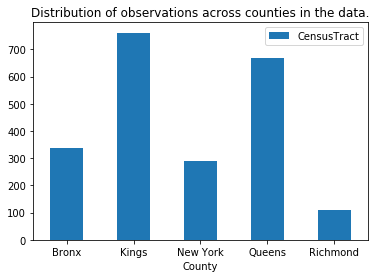

In [9]:
df_census = pd.read_csv("data/nyc_census_tracts.csv")
fig, ax = plt.subplots(1,1)
df_census.groupby("County").count().plot.bar(y="CensusTract", ax=ax, rot=0)
plt.title("Distribution of observations across counties in the data.")
plt.show()

### Defining the model

The model will be based on the following generative process:

**Generative Process - Hierarchical model** 

<ol>
    <li> Draw parameter $r \sim \text{Gamma}(\alpha, \beta)$ . </li>
    <li> Draw parameter $\sigma^2 \sim \text{HalfCauchy}(\gamma)$. </li>
    <li> For each group $k \in \{1, \dots, K\}$ </li>
    <ol>
        <li> Draw linear coefficients $\beta_k \sim N(\beta_k|\bf{\mu_\beta},\bf{\sigma_\beta}\textbf{I})$</li>
    </ol>
    <li> For the n'th observation </li>
    <ol>
        <li> Draw $\psi_n \sim N(\psi_n | \beta_{k_n}^T\textbf{X}_n, \sigma^2)$</li>
        <li> Compute $p_n$. </li>
        <li> Draw $y_n \sim \text{NB}(r, p_n)$</li>
    </ol>
</ol>

In [10]:
def hierarchical_model(X, k, n_k, obs=None, pred=False):
    
    # Number of observations
    N, n_feat = X.shape
    
    # Hyperparameters
    r_gamma1 = 2
    r_gamma2 = 2
    sigma_gamma = 1

    # Draw parameters.
    r = pyro.sample("r", dist.Gamma(r_gamma1, r_gamma2))
    sigma = pyro.sample("sigma", dist.HalfCauchy(sigma_gamma))
    
    with pyro.plate("group", n_k):
        # Draw the parameters for each group
        beta = pyro.sample(
            "beta",
            dist.Normal(torch.zeros(n_feat), torch.ones(n_feat)).to_event()
        )
        
    with pyro.plate("observations", N):
        psi_mu = torch.sum(X * beta[k], axis=1)
        
        # Sample psi
        if pred:
            psi = dist.Normal(psi_mu, sigma).sample()
        else:
            psi = pyro.sample("psi", dist.Normal(psi_mu, sigma))
            
        pred = pyro.sample(
            "pred",
            dist.NegativeBinomial(r, logits=psi),
            obs=obs
        )
    
    return pred

In [11]:
# Prepare data for Pyro model
if not torch.is_tensor(X_train):
    X_train = torch.tensor(X_train).float()
    y_train = torch.tensor(y_train).float()
    k_train = torch.tensor(k_train).long() # these are indices, therefore they need to be (long) integers
n_k = len(np.unique(np.concatenate(k)))

In [12]:
%%time

# Define guide function.
guide = AutoDiagonalNormal(hierarchical_model)

# Reset parameter values.
pyro.clear_param_store()

# Define the number of optimization steps.
n_steps = 2000

# Setup the optimizer.
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm.
elbo = Trace_ELBO(num_particles=1)
svi = SVI(hierarchical_model, guide, optimizer, loss=elbo)

# Do gradient steps.
t = tqdm(range(n_steps))
for step in t:
    elbo = svi.step(X_train, k_train, n_k, y_train)
    
    # display the epoch training loss
    t.set_description("{:d} ELBO: {:.1f}".format(step+1, elbo))
    t.refresh() # to show immediately the update

2000 ELBO: 5544.7: 100%|██████████| 2000/2000 [00:20<00:00, 99.81it/s] 

CPU times: user 22.3 s, sys: 2.51 s, total: 24.8 s
Wall time: 20 s


##### Visualizations of variable differences from county to county

In [17]:
from pyro.infer import Predictive

predictive = Predictive(hierarchical_model, guide=guide, num_samples=1000,
                        return_sites=("beta", "r", "pred", "sigma"))
samples = predictive(X_train, k_train, n_k, y_train)
preds = predictive(torch.from_numpy(X_test).float(), k_test, n_k, pred=True)

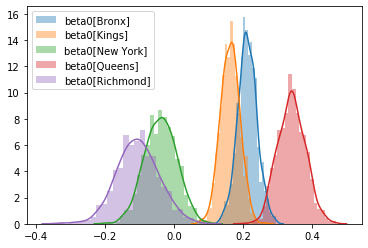

In [14]:
beta_samples = samples["beta"].detach().numpy()
beta_index = 0

for k_ in range(n_k):
    sns.distplot(beta_samples[:,k_,beta_index])
plt.legend([f"beta0[%s]" % county_map[c] for c in range(n_k)])
plt.show()

##### MSE for model

In [19]:
beta_samples = samples["beta"].detach().numpy()
r_samples = samples["r"].detach().numpy()

beta = beta_samples.mean(axis=0)
r = r_samples.mean(axis=0)
psi = np.sum(beta[k_test] * X_test, axis=1)
d = dist.NegativeBinomial(torch.tensor(r), logits=torch.tensor(psi))
y_hat = np.array(d.mean)
print("MSE   (mean):", sum((y_hat - y_test)**2)/len(y_hat))

beta = np.median(beta_samples, axis=0)
r = np.median(r_samples, axis=0)
psi = np.sum(beta[k_test] * X_test, axis=1)
d = dist.NegativeBinomial(torch.tensor(r), logits=torch.tensor(psi))
y_hat2 = np.array(d.mean)
print("MSE (median):", sum((y_hat2 - y_test)**2)/len(y_test))

y_hat3 = preds["pred"].detach().numpy().mean(axis=0)
print("MSE (predictive):", sum((y_hat3 - y_test)**2)/len(y_test))

MSE   (mean): 45.04729277235073
MSE (median): 45.056375354838906
MSE (predictive): 55.454267757358004


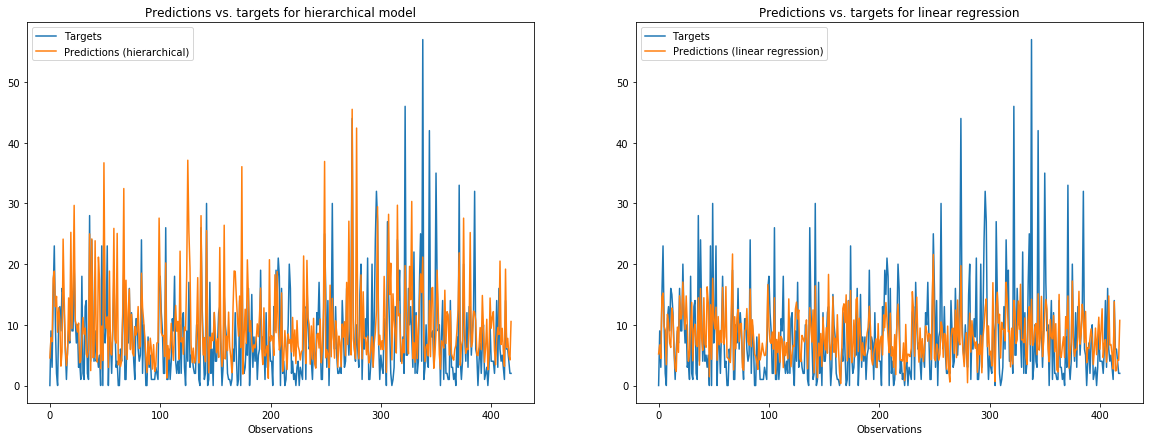

In [20]:
fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].plot(y_test, label="Targets")
ax[0].plot(y_hat3, label="Predictions (hierarchical)")
ax[0].legend()
ax[0].set_xlabel("Observations")
ax[0].set_title("Predictions vs. targets for hierarchical model")

ax[1].plot(y_test, label="Targets")
ax[1].plot(y_hat_lreg, label="Predictions (linear regression)")
ax[1].legend()
ax[1].set_xlabel("Observations")
ax[1].set_title("Predictions vs. targets for linear regression")
plt.show()

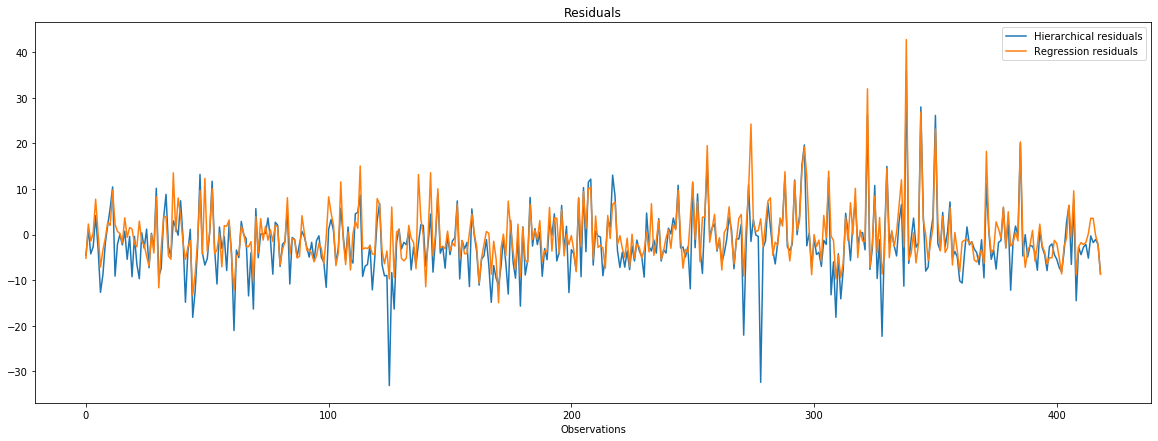

In [21]:
fig, ax = plt.subplots(1,1, figsize=(20,7))

ax.plot(y_test-y_hat3, label="Hierarchical residuals")
ax.plot(y_test-y_hat_lreg, label="Regression residuals")
ax.legend()
ax.set_xlabel("Observations")
plt.title("Residuals")
plt.show()

## Combining the neural network model and the hierarchical model

We saw that neither the neural network nor the hierarchical model managed to outperform the linear regression. <br>
Therefore, we try to combine the two models. We select a subset of features $\textbf{X}' \subseteq \textbf{X}$ which will be modelled using the hierarchical parameter vector $\beta_k$ and the complement of the set $\textbf{X} \backslash \textbf{X}' = \textbf{X}^*$ which will then go into the neural network. This gives us the following generative process

**Generative Process - Hierarchical model + neural network**
<ol>
    <li> Draw parameter $r \sim \text{Gamma}(\alpha, \beta)$ . </li>
    <li> Draw parameter $\sigma^2 \sim \text{HalfCauchy}(\gamma)$. </li>
    <li> Draw coefficients for neural net $\theta \sim N(\theta|\textbf{0},\tau \textbf{I})$</li>
    <li> For each group $k \in \{1, \dots, K\}$ </li>
    <ol>
        <li> Draw linear coefficients $\beta_k \sim N(\beta|\bf{\mu_\beta},\bf{\sigma_\beta}\textbf{I})$</li>
    </ol>
    <li> For the n'th observation </li>
    <ol>
        <li> Draw $\psi_n \sim N(\psi_n | \beta_{k_n}^T\textbf{X}'_n+f_{\text{nnet}}(\textbf{X}^*_n), \sigma^2)$</li>
        <li> Compute $p_n$. </li>
        <li> Draw $y_n \sim \text{NB}(r, p_n)$</li>
    </ol>
</ol>

#### Splitting up the features

In order to determine which features go into $\textbf{X}'$ and which go into $\textbf{X}^*$, we perform a feature selection using the LARS-algorithm [REFERENCE TIL LARS].

In [22]:
from sklearn import linear_model

lars = linear_model.Lars(n_nonzero_coefs=8)
lars.fit(X_train, y_train)
linear_ids = lars.coef_ != 0
linear_ids = np.array([i for i, incl in enumerate(linear_ids) if incl])
print("Linear features: ", linear_ids)

Linear features:  [ 0  1  2  9 10 18 21 27]


In [23]:
def hierarchical_nn_model(X, linear_ids, k, n_k, obs=None, pred=False):
    # Number of observations
    N, lin_feat = X[:, linear_ids].shape
    nn_feat = X.shape[1]
    
    # Hyperparameters
    r_gamma1 = 5
    r_gamma2 = 2
    sigma_gamma = 1

    # Draw parameters.
    r = pyro.sample("r", dist.Gamma(r_gamma1, r_gamma2).to_event())
    sigma = pyro.sample("sigma", dist.HalfCauchy(sigma_gamma).to_event())
    
    # Artificial neural network parameters
    w1 = pyro.sample("w1", dist.Normal(torch.zeros(nn_feat, 8), torch.ones(nn_feat, 8)).to_event())
    b1 = pyro.sample("b1", dist.Normal(torch.zeros(8), torch.ones(8)).to_event())
    w2 = pyro.sample("w2", dist.Normal(torch.zeros(8, 4), torch.ones(8, 4)).to_event())
    b2 = pyro.sample("b2", dist.Normal(torch.zeros(4), torch.ones(4)).to_event())
    w3 = pyro.sample("w3", dist.Normal(torch.zeros(4, 1), torch.ones(4, 1)).to_event())
    b3 = pyro.sample("b3", dist.Normal(torch.zeros(1), torch.ones(1)).to_event())
    
    with pyro.plate("group", n_k):
        # Draw the parameters for each group
        beta = pyro.sample(
            "beta",
            dist.Normal(torch.zeros(lin_feat), torch.ones(lin_feat)).to_event()
        )
    
    with pyro.plate("data", N):
        # Draw for observations.
        # NN forward pass
        x_nn = torch.relu(torch.matmul(X, w1) + b1)
        x_nn = torch.relu(torch.matmul(x_nn, w2) + b2)
        x_nn = torch.matmul(x_nn, w3) + b3

        # Combine non linear and linear features
        lin_contr = torch.sum(X[:, linear_ids] * beta[k], axis=1)
        psi_mu = lin_contr + x_nn.ravel()
        
        if pred:
            psi = dist.Normal(psi_mu, sigma).sample()
        else:
            psi = pyro.sample("psi", dist.Normal(psi_mu, sigma))
            
        pred = pyro.sample(
            "pred",
            dist.NegativeBinomial(r, logits=psi),
            obs=obs
        )
    
    return pred

In [24]:
%%time

# Define guide function.
nn_guide = AutoDiagonalNormal(hierarchical_nn_model)

# Reset parameter values.
pyro.clear_param_store()

# Define the number of optimization steps.
n_steps = 1000

# Setup the optimizer.
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm.
elbo = Trace_ELBO(num_particles=3)
svi = SVI(hierarchical_nn_model, nn_guide, optimizer, loss=elbo)

# Do gradient steps.
t = tqdm(range(n_steps))
for step in t:
    elbo = svi.step(X_train, linear_ids, k_train, n_k, y_train)
    
    # display the epoch training loss
    t.set_description("{:d} ELBO: {:.1f}".format(step+1, elbo))
    t.refresh() # to show immediately the update

1000 ELBO: 5109.5: 100%|██████████| 1000/1000 [00:35<00:00, 27.88it/s]

CPU times: user 34.1 s, sys: 1.79 s, total: 35.9 s
Wall time: 35.9 s


#### Predict with the model

In [27]:
predictive = Predictive(hierarchical_nn_model, guide=nn_guide, num_samples=1000,
                        return_sites=())
samples = predictive(X_train, linear_ids, k_train, n_k)
preds = predictive(torch.from_numpy(X_test).float(), linear_ids, k_test, n_k, pred=True)

In [28]:
beta = samples["beta"].detach().numpy().mean(axis=0)
r = samples["r"].detach().numpy().mean(axis=0)
w1 = samples["w1"].mean(axis=0)
b1 = samples["b1"].mean(axis=0)
w2 = samples["w2"].mean(axis=0)
b2 = samples["b2"].mean(axis=0)
w3 = samples["w3"].mean(axis=0)
b3 = samples["b3"].mean(axis=0)

# NN forward pass 
x_test_nn = torch.tanh(torch.tanh(torch.from_numpy(X_test).float() @ w1 + b1) @ w2 + b2) @ w3 + b3

# Propagate through rest of model
psi = np.sum(beta[k_test] * X_test[:, linear_ids], axis=1) + x_test_nn.detach().numpy().ravel()
d = dist.NegativeBinomial(torch.tensor(r), logits=torch.tensor(psi))
y_hat = np.array(d.mean)
# evaluate prediction accuracy
print("MSE (mean):", sum((y_hat - y_test)**2)/len(y_hat))

beta = np.median(samples["beta"].detach().numpy(), axis=0)
r = np.median(samples["r"].detach().numpy(), axis=0)
psi = np.sum(beta[k_test] * X_test[:, linear_ids], axis=1) + x_test_nn.detach().numpy().ravel()
d = dist.NegativeBinomial(torch.tensor(r), logits=torch.tensor(psi))
y_hat = np.array(d.mean)
# evaluate prediction accuracy
print("MSE (median):", sum((y_hat - y_test)**2)/len(y_hat))

y_hat3 = preds["pred"].detach().numpy().mean(axis=0)
print("MSE (predictive):", sum((y_hat3 - y_test)**2)/len(y_test))

MSE (mean): 42.84205363041076
MSE (median): 42.87557485833923
MSE (predictive): 41.2190399744459


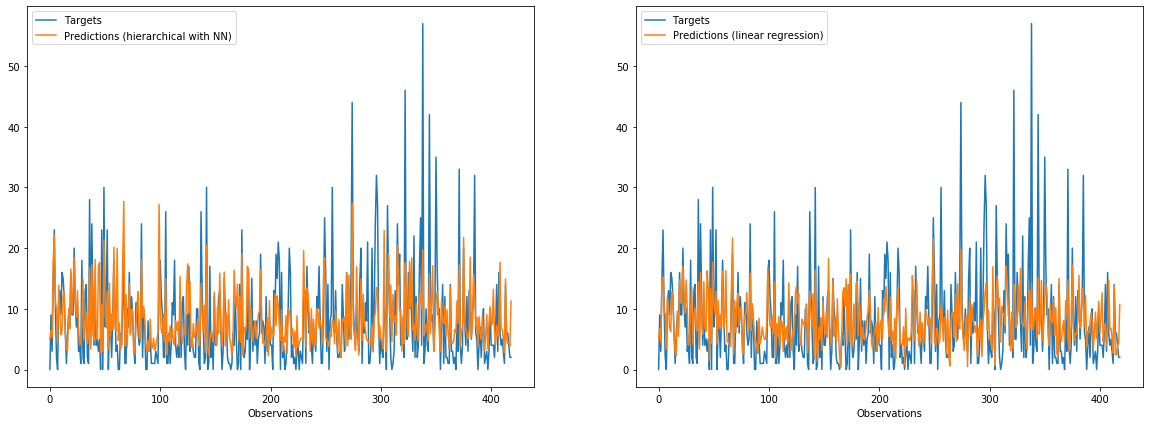

In [29]:
fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].plot(y_test, label="Targets")
ax[0].plot(y_hat3, label="Predictions (hierarchical with NN)")
ax[0].legend()
ax[0].set_xlabel("Observations")

ax[1].plot(y_test, label="Targets")
ax[1].plot(y_hat_lreg, label="Predictions (linear regression)")
ax[1].legend()
ax[1].set_xlabel("Observations")
plt.show()

[]

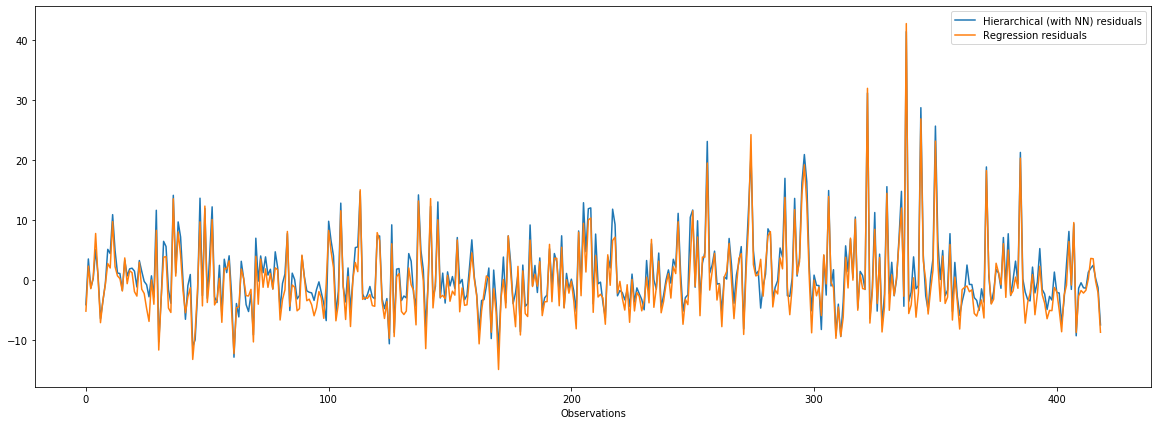

In [30]:
fig, ax = plt.subplots(1,1, figsize=(20,7))

ax.plot(y_test-y_hat, label="Hierarchical (with NN) residuals")
ax.plot(y_test-y_hat_lreg, label="Regression residuals")
ax.legend()
ax.set_xlabel("Observations")
plt.plot()